# Dependencies

In [7]:
from io import BytesIO
from pdf2image import convert_from_path
from os import listdir, makedirs
from os.path import isfile, join
from tqdm import tqdm
from glob import glob
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import math

In [21]:
PDF_PATH = "../dataset/pdf"
IMAGE_PATH = "../dataset/image"

# Set plot size
plt.rcParams["figure.figsize"] = 15, 15

# Image Import

## Conversion from PDF to PNG (optional)

In [6]:
for filepath in tqdm(listdir(PDF_PATH)):
    images = convert_from_path(''.join([PDF_PATH, '/', filepath]))
    filename = filepath.split('.')[0]
    makedirs(''.join([IMAGE_PATH, '/', filename]))
    for index, image in enumerate(images):
        image.save(''.join([IMAGE_PATH, '/', filename, '/', str(index), '.png']), 'PNG')


  0%|          | 0/132 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Importing PNG

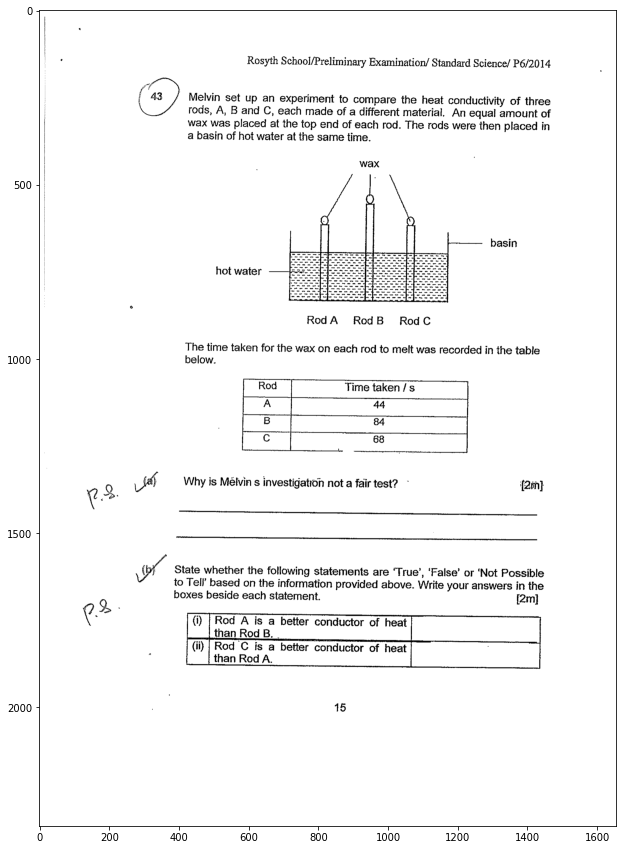

In [22]:
filenames = glob(''.join([IMAGE_PATH, '/*/*.png']))
filenames.sort()
image = cv.imread(filenames[85], cv.IMREAD_GRAYSCALE)
plt.imshow(image, cmap = 'gray')

## Otsu Binarization

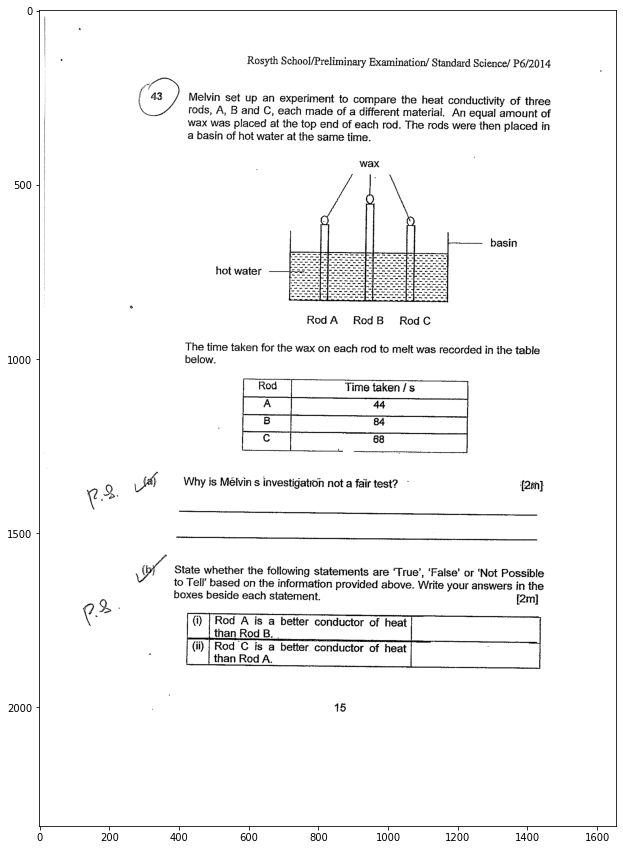

In [23]:
original, binarized = cv.threshold(image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
plt.imshow(binarized, cmap = 'gray')

## Skew correction

All deviation angles: [-0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -2.5044781672654157e-06, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -2.5044781672654157e-06, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -2.5044781672654157e-06, -2.5044781672654157e-06, -2.5044781672654157e-06, -2.5044781672654157e-06, -0.999996840481394, -0.999996840481394, -2.5044781672654157e-06, -0.999996840481394, -2.5044781672654157e-06, -2.5044781672654157e-06, -0.999996840481394, -0.999996840481394, -0.999996840481394, -2.5044781672654157e-06, -0.999996840481394, -2.5044781672654157e-06, -2.5044781672654157e-06, -0.999996840481394, -0.999996840481394, -0.999996840481394, -0.999996840481394, -2.5044781672654157e-06, -2.5044781672654157e-06, -0.9999

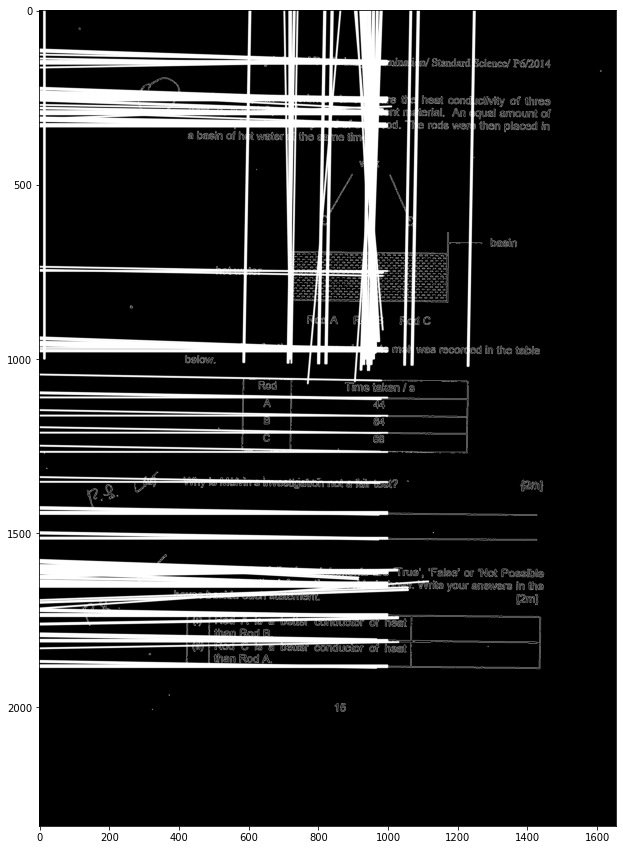

In [44]:
cannied = cv.Canny(binarized, 50, 200, None, 3)
underlay = np.copy(cannied)

# For ease of view
lines = cv.HoughLines(cannied, 1, np.pi / 180, 180, None, 0, 0)
skew_angles = []
if lines is not None:
    for line in lines:
        rho = line[0][0]
        theta = line[0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(underlay, pt1, pt2, (255, 255, 255), 3, cv.LINE_AA)
                       
        # Get only horizontal lines (i.e Lines with |angle| < 45 from horizontal)
        # Getting other angle of right angled triangle thereby retrieving the deviation angle via congruent alternate internal angles
        dev_from_hrzntal_in_rad = np.pi / 2 - theta 
        
        # Conversion to deg
        dev_from_hrzntal_in_deg = dev_from_hrzntal_in_rad / np.pi * 180
        
        if (abs(dev_from_hrzntal_in_deg) < 45):
            skew_angles.append(dev_from_hrzntal_in_deg)
        
# Get average of all horizontal lines angle only
print(f'All deviation angles: {skew_angles}')
print(f'Number of lines: {len(lines)}')

deskew_angle = sum(skew_angles) / len(skew_angles)
print(f'Deskew Angle: {deskew_angle}')

plt.imshow(underlay, cmap="gray")


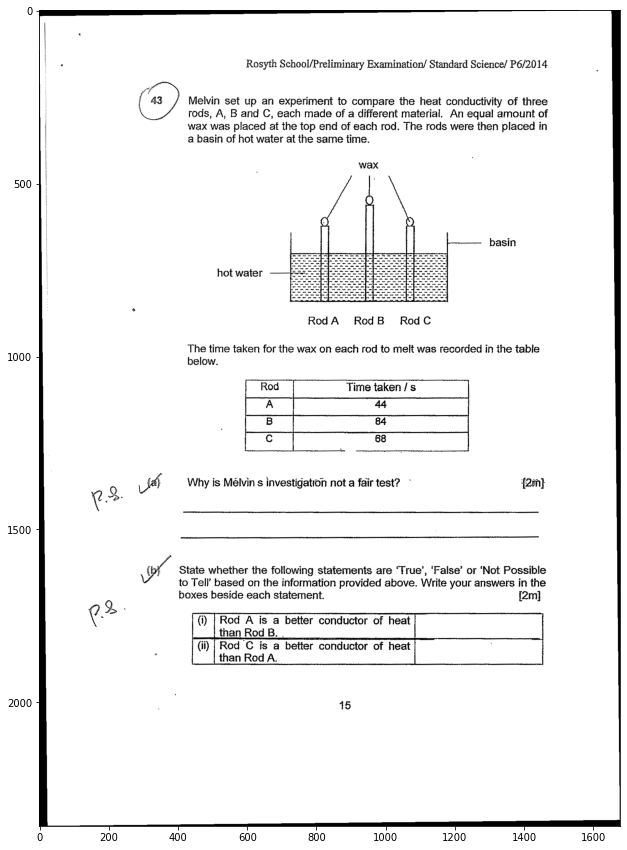

In [39]:
deskewed_image = ndimage.rotate(binarized, -deskew_angle)
plt.imshow(deskewed_image, cmap = 'gray')